# Machine Learning Explainability
todo: mention h2o
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
SHAP docs
https://shap.readthedocs.io/

http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

## Tree ensemble example with TreeExplainer 
SHAP can explain the output of any machine learning model developed using XGBoost/LightGBM/CatBoost/scikit-learn. Please refer to the following [Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888) paper for more details regarding tree ensemble methods.

In [1]:
import joblib
import xgboost
import shap
import pickle
import warnings
import numpy as np
shap.initjs()

raw_features_not_to_use = ["DepTime", "ArrTime", "TailNum", "ActualElapsedTime", "AirTime", "ArrDelay",
                   "DepDelay", "TaxiIn", "TaxiOut",  "CancellationCode", "Diverted", "CarrierDelay",
                   "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "IsArrDelayed", "IsDepDelayed"]
    
raw_features_to_use = ["Year", "Month", "DayofMonth", "DayOfWeek", "CRSDepTime", 
                                          "CRSArrTime", "UniqueCarrier", "FlightNum", "CRSElapsedTime", 
                                          "Origin", "Dest", "Distance", "Cancelled"] 
raw_features_to_encode = ['UniqueCarrier','Dest','Origin']

#load saved model
model = joblib.load("../data/processed/model_xgboost")
pickle_in = open("../data/processed/airlines_train_set.pkl","rb")
train_set = pickle.load(pickle_in)
train_set.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,Distance,Cancelled,...,Origin_STX,Origin_SWF,Origin_SYR,Origin_TLH,Origin_TPA,Origin_TRI,Origin_TUL,Origin_TUS,Origin_TYS,Origin_UCA
11568,1992,1,3,5,700,746,84,46.0,166.0,1,...,0,0,0,0,0,0,0,0,0,0
35854,2004,1,26,1,1300,1512,509,132.0,758.0,0,...,0,0,0,0,0,0,0,0,0,0
39071,2006,1,11,3,1608,2239,683,271.0,2133.0,0,...,0,0,0,0,0,0,0,0,0,0
7514,1990,1,3,3,1155,1229,54,34.0,85.0,0,...,0,0,0,0,0,0,0,0,0,0
18945,1996,1,3,3,848,1055,860,247.0,1671.0,0,...,0,0,0,0,0,0,0,0,0,0


### Classic global feature importance measures
Weight. The number of times a feature is used to split the data across all trees.
Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
Gain. The average training loss reduction gained when using a feature for splitting.

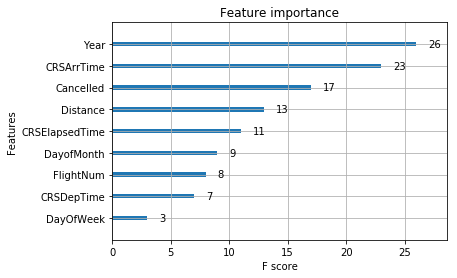

In [18]:
xgboost.plot_importance(model,importance_type='weight')

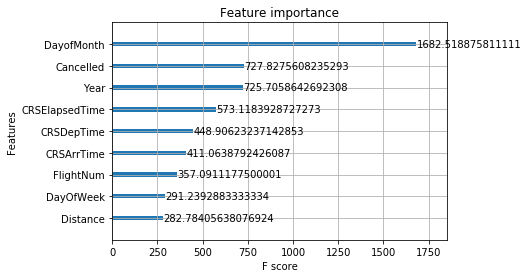

In [16]:
xgboost.plot_importance(model,importance_type='cover')

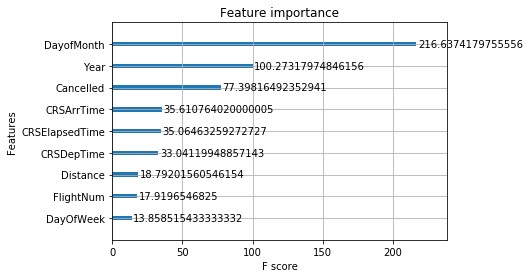

In [17]:
xgboost.plot_importance(model,importance_type='gain')

In [3]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_set)
shap_values

array([[ 0.00497132,  0.        ,  0.00143865, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02655197,  0.        , -0.01773717, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01691595,  0.        , -0.01201779, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01262409,  0.        , -0.00818394, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01231117,  0.        , -0.0079662 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0184896 ,  0.        , -0.01344304, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [4]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], train_set.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [5]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:5], train_set.iloc[0:5, :])

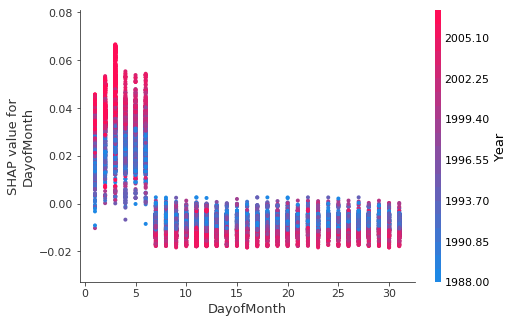

In [6]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("DayofMonth", shap_values, train_set)

In [7]:
train_set.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'FlightNum', 'CRSElapsedTime', 'Distance', 'Cancelled',
       ...
       'Origin_STX', 'Origin_SWF', 'Origin_SYR', 'Origin_TLH', 'Origin_TPA',
       'Origin_TRI', 'Origin_TUL', 'Origin_TUS', 'Origin_TYS', 'Origin_UCA'],
      dtype='object', length=285)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

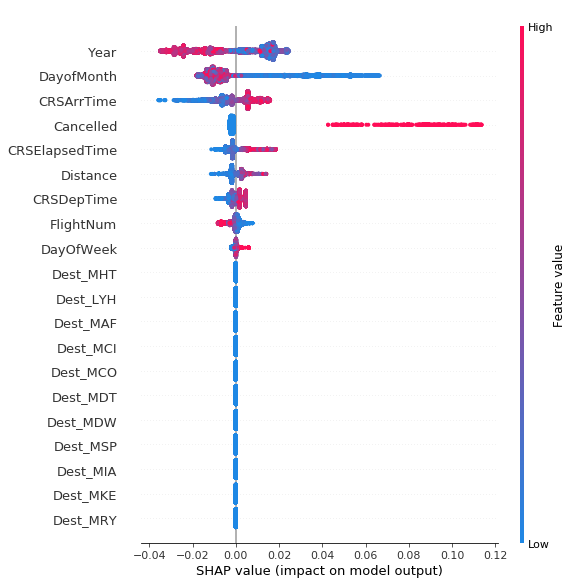

In [13]:
shap.summary_plot(shap_values, train_set)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

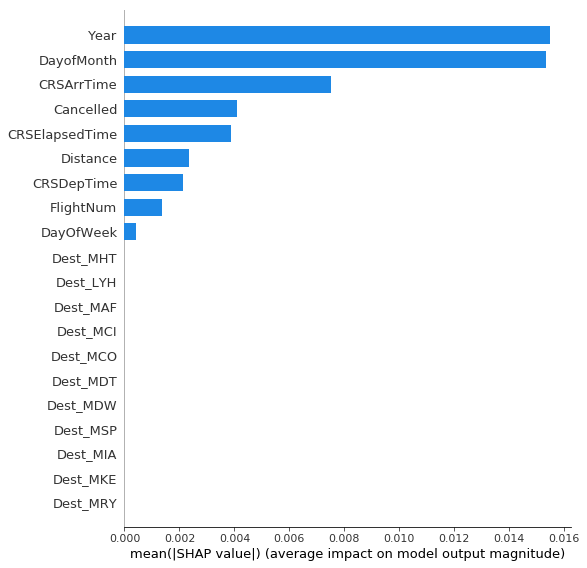

In [8]:
shap.summary_plot(shap_values, train_set, plot_type="bar")

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that RM has less impact on home price for areas close to radial highways.

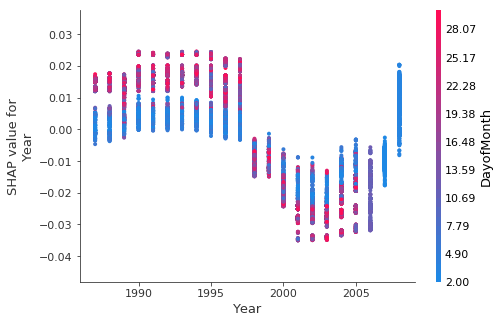

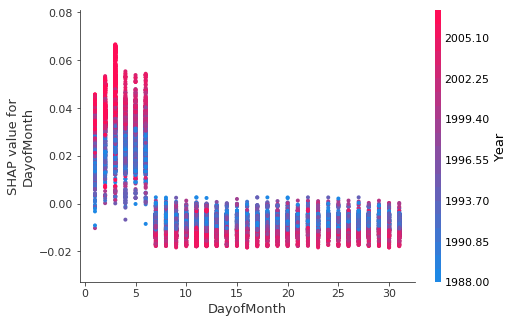

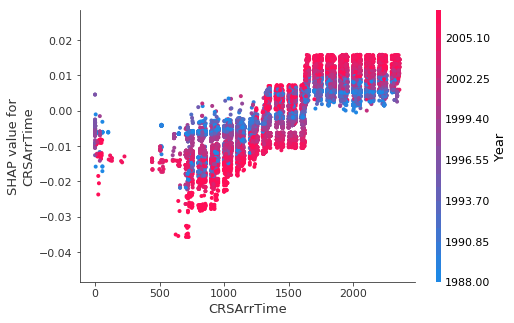

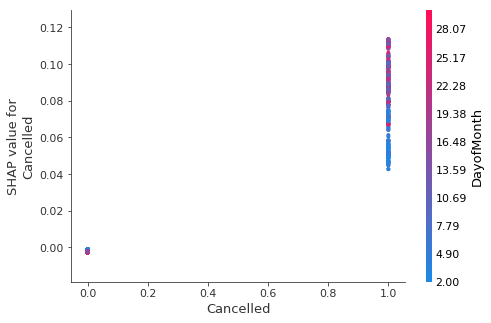

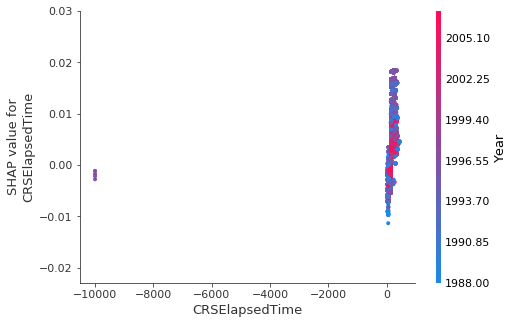

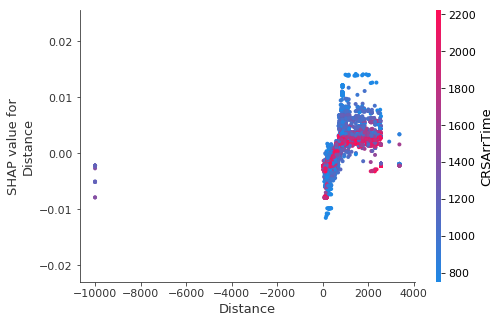

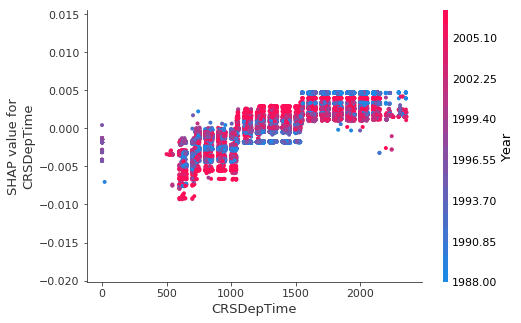

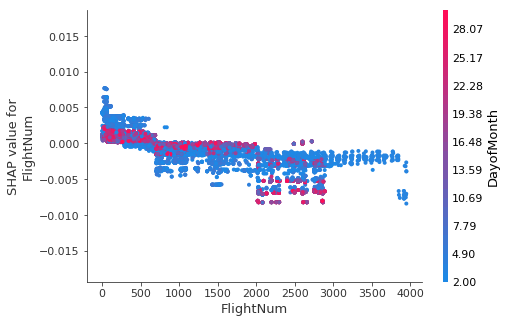

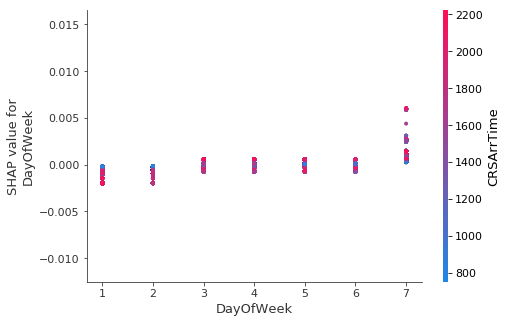

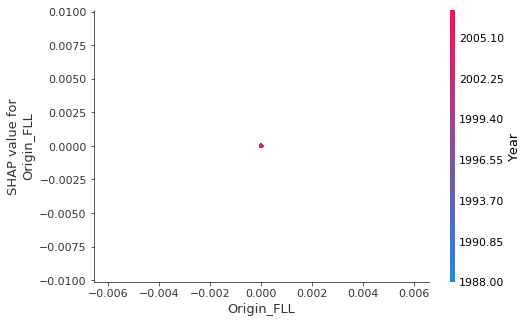

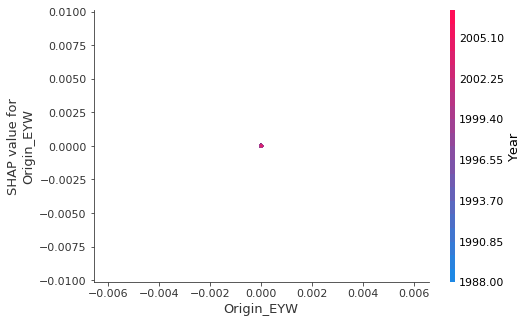

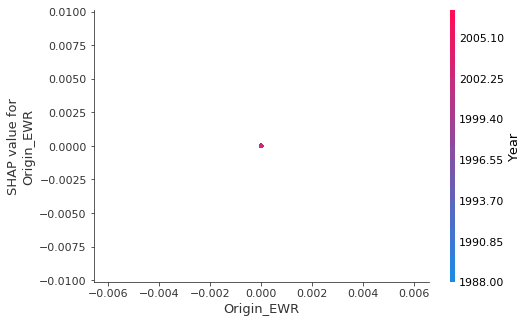

In [12]:
import numpy as np
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(12):
    shap.dependence_plot(top_inds[i], shap_values, train_set)